In [1]:
from community_knapsack import *
from evaluation import evalutils
import matplotlib.pyplot as plt
# import matplotlib as mpl
# mpl.use('macosx')
%matplotlib inline

In [2]:
# Algorithms
exact_algorithms = [
    PBSingleAlgorithm.MEMOIZATION,
    PBSingleAlgorithm.DYNAMIC_PROGRAMMING,
    PBSingleAlgorithm.BRANCH_AND_BOUND,
    PBSingleAlgorithm.ILP_SOLVER
]
exact_labels = ['MEM', 'DYP', 'BRB', 'IPS']

approximation_algorithms = [
    PBSingleAlgorithm.GREEDY,
    PBSingleAlgorithm.RATIO_GREEDY,
    PBSingleAlgorithm.FPTAS,
    PBSingleAlgorithm.SIMULATED_ANNEALING,
    PBSingleAlgorithm.GENETIC_ALGORITHM
]
approximation_labels = ['GRE', 'RAG', 'FPA', 'SIA', 'GEN']

# PyPlot Configuration
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
alpha_cycle = [1.0] * max(len(exact_labels), len(approximation_labels))
marker_size_cycle = [15] * max(len(exact_labels), len(approximation_labels))

In [3]:
# This notebook explores the runtime and value of algorithms as both the number of projects and the budget increases:

In [4]:
# Generate Problems
generator = PBGenerator(seed=181)

min_projects = 20
max_projects = 100
step_projects = 20

num_voters = 3000

min_budget = 100_000
max_budget = 1_000_000
step_budget = 100_000

cost_bound = (5_000, 50_000)

problems = []
for num_projects in range(min_projects, max_projects + 1, step_projects):
    for budget in range(min_budget, max_budget + 1, step_budget):
        problems.append(generator.generate_single_problem(
            num_projects_bound=(num_projects, num_projects),
            num_voters_bound=(num_voters, num_voters),
            budget_bound=(budget, budget),
            cost_bound=cost_bound
        ))

In [5]:
def format_results(flat_results):
    formatted = []
    current_result = 0
    for np in range(min_projects, max_projects + 1, step_projects):
        np_results = []
        for b in range(min_budget, max_budget + 1, step_budget):
            np_results.append(flat_results[current_result])
            current_result += 1
        formatted.append(np_results)
    return formatted

In [6]:
exact_results = format_results(evalutils.solve_problems(problems, exact_algorithms, timeout=40, max_fail=-1, file_name='ext-increasing-both.txt', output=True))

In [7]:
approximation_results = format_results(evalutils.solve_problems(problems, approximation_algorithms, timeout=40, max_fail=-1, file_name='apx-increasing-both.txt', output=True))

In [8]:
x_axis = list(range(min_projects, max_projects + 1, step_projects))
y_axis = list(range(min_budget, max_budget + 1, step_budget))

In [9]:
def plot_3d(results, algorithms, tuple_idx=2, x_label='', y_label='', z_label='', labels=None, colours=None, alphas=None, sizes=None):
    x_flat = [x for x in x_axis for y in y_axis]
    y_flat = [y for x in x_axis for y in y_axis]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)

    for idx, algorithm in enumerate(algorithms):
        z_flat = [results[i][j][algorithm.name][tuple_idx] for i in range(len(x_axis)) for j in range(len(y_axis))]
        x_reduced = [xv for xi, xv in enumerate(x_flat) if z_flat[xi]]
        y_reduced = [yv for yi, yv in enumerate(y_flat) if z_flat[yi]]
        z_reduced = [zv for zv in z_flat if zv]
        ax.scatter(x_reduced, y_reduced, z_reduced, alpha=alphas[idx], label=labels[idx], c=colours[idx], s=sizes[idx])

    legend = plt.legend()
    for idx in range(len(labels if labels else [])):
        legend.legend_handles[idx].set_sizes(marker_size_cycle)
        legend.legend_handles[idx].set_alpha(alpha_cycle[0])
    plt.show()

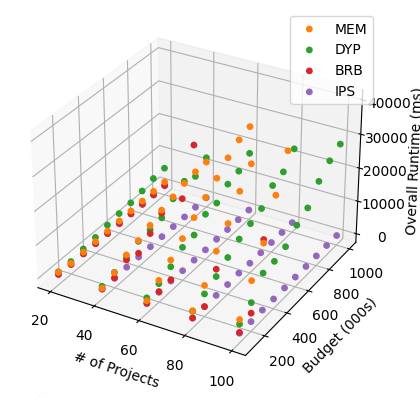

In [10]:
# EXACT ALGORITHMS RUNTIME OVER THE PROBLEMS
plot_3d(exact_results, exact_algorithms, x_label='# of Projects', y_label='Budget (000s)', z_label='Overall Runtime (ms)', labels=exact_labels, colours=color_cycle[1:], alphas=alpha_cycle, sizes=marker_size_cycle)

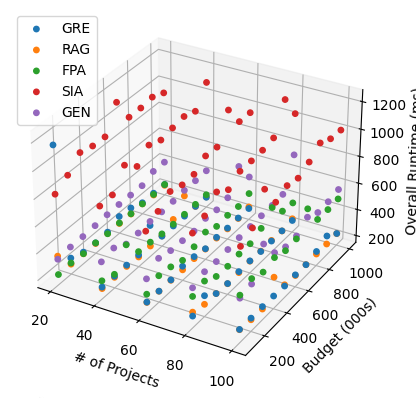

In [11]:
# APPROXIMATION ALGORITHMS RUNTIME OVER THE PROBLEMS
plot_3d(approximation_results, approximation_algorithms, x_label='# of Projects', y_label='Budget (000s)', z_label='Overall Runtime (ms)', labels=approximation_labels, colours=color_cycle, alphas=alpha_cycle, sizes=marker_size_cycle)

In [12]:
# APPROXIMATION ALGORITHMS VALUES OVER THE PROBLEMS
tmp_approximation = format_results(evalutils.solve_problems(problems, approximation_algorithms, timeout=40, max_fail=-1, file_name='apx-increasing-both.txt', output=True))
for i, p in enumerate(tmp_approximation):
    for j, b in enumerate(p):
        exact = {PBSingleAlgorithm.ILP_SOLVER.name: exact_results[i][j][PBSingleAlgorithm.ILP_SOLVER.name]}
        exact.update(tmp_approximation[i][j])
        tmp_approximation[i][j] = exact

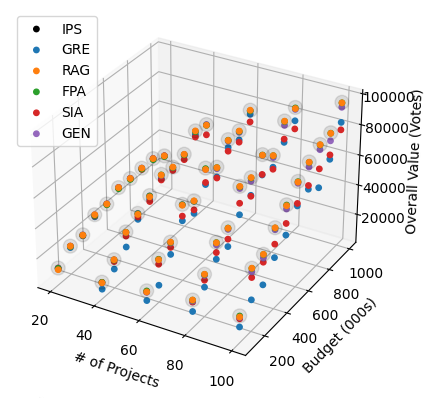

In [13]:
plot_3d(tmp_approximation, [PBSingleAlgorithm.ILP_SOLVER] + approximation_algorithms, tuple_idx=0, x_label='# of Projects', y_label='Budget (000s)', z_label='Overall Value (Votes)', labels=['IPS'] + approximation_labels, colours=['black'] + color_cycle, alphas=[0.1] + alpha_cycle, sizes=[100] + marker_size_cycle)